In [2]:
cuckoo_new = r'C:\Users\bilal\Downloads\AFN project\cuckoo_new.wav'
file_path_1 = r'C:\Users\bilal\Downloads\AFN project\non_cuckoo.wav'

Epoch 1/30
27/27 [==============================] - 21s 651ms/step - loss: 0.8205 - accuracy: 0.7595 - val_loss: 0.3739 - val_accuracy: 0.8905 - lr: 1.0000e-04
Epoch 2/30
27/27 [==============================] - 16s 598ms/step - loss: 0.6139 - accuracy: 0.8429 - val_loss: 0.3593 - val_accuracy: 0.9095 - lr: 1.0000e-04
Epoch 3/30
27/27 [==============================] - 16s 586ms/step - loss: 0.5445 - accuracy: 0.8238 - val_loss: 0.3493 - val_accuracy: 0.9143 - lr: 1.0000e-04
Epoch 4/30
27/27 [==============================] - 16s 600ms/step - loss: 0.4069 - accuracy: 0.8512 - val_loss: 0.3527 - val_accuracy: 0.9143 - lr: 1.0000e-04
Epoch 5/30
27/27 [==============================] - 16s 594ms/step - loss: 0.3553 - accuracy: 0.8655 - val_loss: 0.3349 - val_accuracy: 0.9143 - lr: 1.0000e-04
Epoch 6/30
27/27 [==============================] - 16s 611ms/step - loss: 0.3787 - accuracy: 0.8738 - val_loss: 0.3387 - val_accuracy: 0.9143 - lr: 1.0000e-04
Epoch 7/30
27/27 [======================

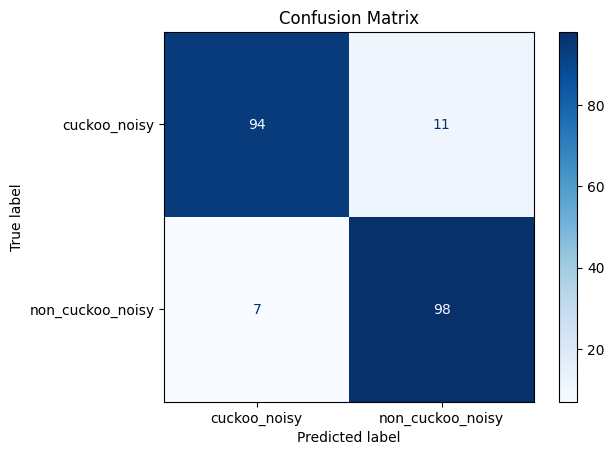

In [43]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# addind white noise to the audio
def add_white_noise(audio, snr=30):
    signal_power = np.mean(audio**2)
    noise_power = signal_power / (10**(snr / 10))
    noise = np.random.normal(0, np.sqrt(noise_power), audio.shape)
    return audio + noise

# splitting the audio into clips
def split_audio_into_clips(audio_path, clip_duration=3):
    audio, sr = librosa.load(audio_path, sr=None)
    clips = []
    num_samples = int(clip_duration * sr)

    for start in range(0, len(audio), num_samples):
        end = start + num_samples
        if end <= len(audio):
            clips.append(audio[start:end])
    return clips, sr

# generating spectograms with white noise
def generate_spectrograms(audio_clips, sr, output_dir, snr=30):
    os.makedirs(output_dir, exist_ok=True)

    for i, clip in enumerate(audio_clips):
        noisy_clip = add_white_noise(clip, snr=snr)
        mel_spectrogram = librosa.feature.melspectrogram(y=noisy_clip, sr=sr, n_mels=64, fmax=8000)
        db_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        plt.figure(figsize=(12, 6))
        librosa.display.specshow(db_mel_spectrogram, sr=sr, hop_length=512, x_axis='time', y_axis='mel', fmax=8000)
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Mel Spectrogram {i + 1}")
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"clip_{i + 1}.png"))
        plt.close()

def prepare_dataset_with_errors(data_dir, error_rate=0.1):
    """
    Prepares the dataset from spectrogram images, intentionally introducing label errors.

    Parameters:
        data_dir (str): Path to the directory containing spectrogram images.
        error_rate (float): Fraction of samples to mislabel (0.1 = 10% mislabeling).

    Returns:
        X (numpy.ndarray): Feature dataset (images).
        y (numpy.ndarray): Labels corresponding to each image.
        label_map (dict): Mapping of labels to indices.
    """
    X, y = [], []
    labels = sorted(os.listdir(data_dir))
    label_map = {label: idx for idx, label in enumerate(labels)}

    for label in labels:
        label_dir = os.path.join(data_dir, label)
        for file in os.listdir(label_dir):
            if file.endswith('.png'):
                img_path = os.path.join(label_dir, file)
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                X.append(img_array)
                y.append(label_map[label])

    X = np.array(X) / 255.0
    y = np.array(y)

    # Introduce label errors
    num_errors = int(len(y) * error_rate)
    error_indices = np.random.choice(len(y), size=num_errors, replace=False)
    for idx in error_indices:
        y[idx] = (y[idx] + 1) % len(label_map)  # Flip label (cuckoo -> non_cuckoo or vice versa)

    return X, y, label_map

# crearting MobileNet model
def create_mobilenet_fine_tune_model(input_shape, num_classes, fine_tune_layers=20):
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers[:-fine_tune_layers]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# plotting training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# main script
cuckoo_path = r'C:\Users\bilal\Downloads\AFN project\cuckoo_new.wav'
non_cuckoo_path = r'C:\Users\bilal\Downloads\AFN project\non_cuckoo.wav'
output_dir = r'C:\Users\bilal\Downloads\AFN project\noisy_data1'

#processing Cuckoo and Non-Cuckoo data
cuckoo_clips, sr = split_audio_into_clips(cuckoo_path, clip_duration=3)
generate_spectrograms(cuckoo_clips, sr, os.path.join(output_dir, "cuckoo_noisy"), snr=30)

non_cuckoo_clips, sr = split_audio_into_clips(non_cuckoo_path, clip_duration=3)
generate_spectrograms(non_cuckoo_clips, sr, os.path.join(output_dir, "non_cuckoo_noisy"), snr=30)

X, y, label_map = prepare_dataset_with_errors(output_dir, error_rate=0.1)

#splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# training the model
input_shape = X_train.shape[1:]
model = create_mobilenet_fine_tune_model(input_shape, len(label_map), fine_tune_layers=20)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

# evaluating the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# generating predictions
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred, target_names=label_map.keys()))

# plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

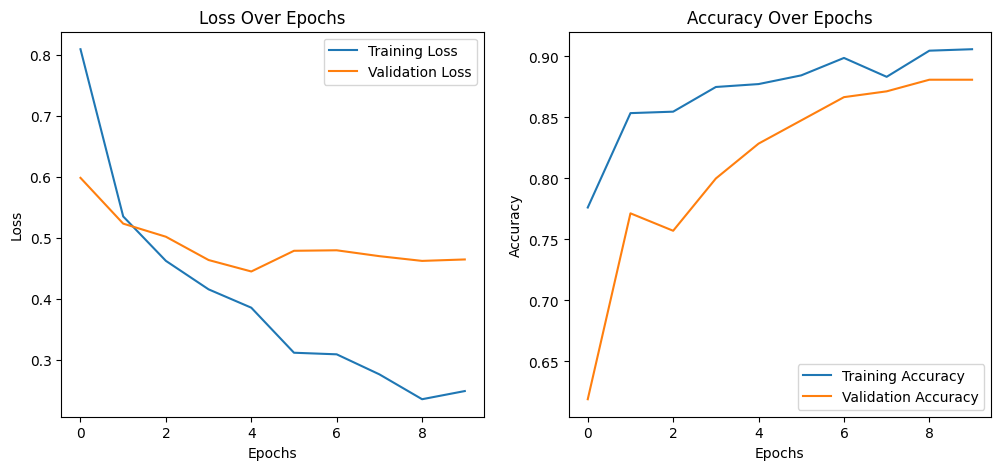

In [47]:
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(history):
    """
    Plots training and validation loss and accuracy over epochs.

    Parameters:
        history: Keras History object obtained from model.fit()
    """
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Call this function with the history object
plot_loss_and_accuracy(history)


7/7 [==============================] - 2s 234ms/step


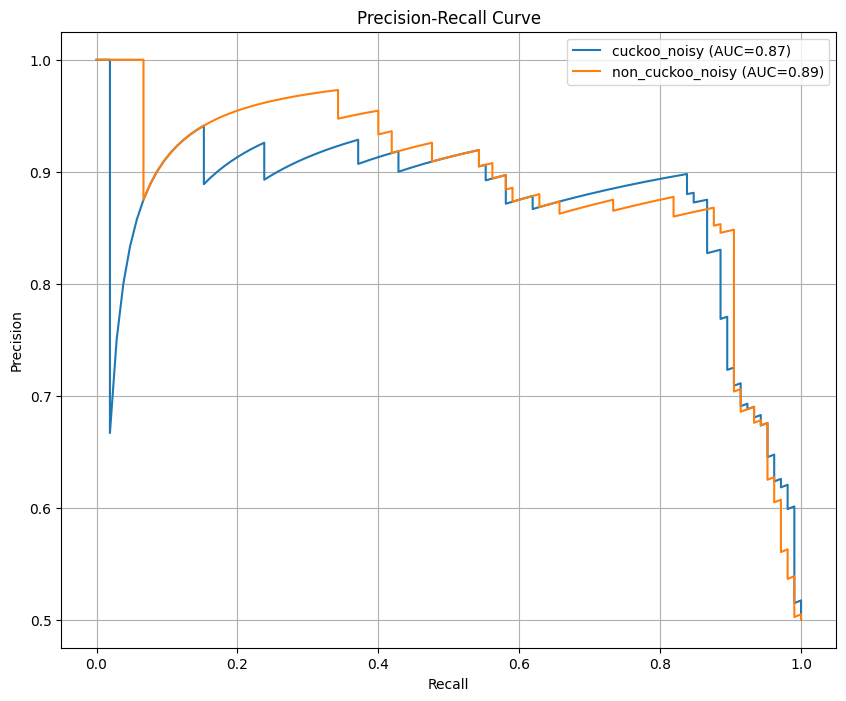

In [49]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

def plot_precision_recall_curve_with_auc(y_test, y_pred_probs, classes):
    """
    Plots the Precision-Recall curve with AUC score for each class.

    Parameters:
        y_test (numpy.ndarray): True labels for the test dataset.
        y_pred_probs (numpy.ndarray): Predicted probabilities for each class.
        classes (list): List of class names.
    """
    plt.figure(figsize=(10, 8))
    
    for i, class_name in enumerate(classes):
        # Calculate precision, recall, and AUC
        precision, recall, _ = precision_recall_curve((y_test == i).astype(int), y_pred_probs[:, i])
        auc_score = average_precision_score((y_test == i).astype(int), y_pred_probs[:, i])
        
        # Plot Precision-Recall curve
        plt.plot(recall, precision, label=f'{class_name} (AUC={auc_score:.2f})')

    # Plot formatting
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Generate predicted probabilities for test data
y_pred_probs = model.predict(X_test)

# Call this function to plot Precision-Recall curve with AUC
plot_precision_recall_curve_with_auc(y_test, y_pred_probs, list(label_map.keys()))